In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
from function_interpolate_Lidar import process_lidar_theodolite

In [81]:
# read the Lidar data
# times are UTC
ws_27_09 = xr.open_dataset('Data_Lidar/20250827_090000.nc')

In [8]:
# read Theodolite data
# times are UTC
date_str = "2025-08-27"
start_time = pd.to_datetime(date_str + " 09:08:09")  # times in df_wxt are UTC + 1

file_path = "Data_Theodolite/TheoRot_20250827_150544.txt"

# Read all lines first
with open(file_path, "r") as f:
    lines = f.readlines()
# Skip last three lines
lines = lines[:-3]
# Lists to store data
time_sec = []
value1 = []
value2 = []

for line in lines:
    line = line.strip()
    if line.startswith("D"):  # data line
        parts = line.split()
        time_sec.append(float(parts[1]))
        value1.append(float(parts[2]))
        value2.append(float(parts[3]))
    elif line.startswith("S"):
        print("Metadata:", line)  # optional

azimuth = np.array(value1) + (231.1-123.93)
azimuth[azimuth > 360] = azimuth[azimuth > 360] - 360
# Create DataFrame
df_theo = pd.DataFrame({
    "time_sec": [start_time + timedelta(seconds=s) for s in time_sec],
    "azimuth": azimuth,
    "elevation": value2})

Metadata: S 25/08/27 09:08:09


In [40]:
# slice Lidar data frame for correct times
t_start = df_theo['time_sec'][0]
t_end   = df_theo['time_sec'].iloc[-1]

ws_27_09_cut = ws_27_09.sel(time=slice(t_start, t_end))

In [61]:
# interpolate Lidar values
#time_lidar = ws_27_09['time'][:]
theo_idx = pd.to_datetime(df_theo['time_sec']).to_numpy()
# Interpolation
ws_27_09_cut_inter = ws_27_09_cut['VEL'].interp(time=theo_idx)  # linear per default

In [69]:
# cut out the valid periods for day 2025-08-27
valid1 = datetime(2025, 8, 27, 9, 21, 0)  # 2025-08-27 11:21:00
valid2 = datetime(2025, 8, 27, 9, 39, 0)  # 2025-08-27 11:39:00
valid3 = datetime(2025, 8, 27, 9, 45, 0)  # 2025-08-27 11:45:00
valid4 = datetime(2025, 8, 27, 9, 53, 0)  # 2025-08-27 11:53:00

VEL_27_09_1 = ws_27_09_cut_inter.sel(time=slice(valid1, valid2))
VEL_27_09_2 = ws_27_09_cut_inter.sel(time=slice(valid3, valid4))
theo_27_09_1 = df_theo[(df_theo['time_sec'] >= valid1) & (df_theo['time_sec'] <= valid2)]
theo_27_09_2 = df_theo[(df_theo['time_sec'] >= valid3) & (df_theo['time_sec'] <= valid4)]

In [83]:
theo_funct, ws_funct = process_lidar_theodolite(
    lidar_file="Data_Lidar/20250827_090000.nc",
    theo_file="Data_Theodolite/TheoRot_20250827_150544.txt",
    date_str="2025-08-27",
    start_time_str="09:08:09",
    azimuth_offset=(231.1 - 123.93)   # wie in deinem Skript
)

print(theo_funct.head())
print(ws_funct)

Metadata: S 25/08/27 09:08:09
             time_sec  azimuth  elevation
0 2025-08-27 09:08:09    82.15       6.45
1 2025-08-27 09:08:14    82.15       6.45
2 2025-08-27 09:08:19    82.15       6.45
3 2025-08-27 09:08:24    72.39       6.45
4 2025-08-27 09:08:29   330.20       6.45
<xarray.DataArray 'VEL' (time: 566, height: 14)> Size: 63kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(566, 14))
Coordinates:
  * height   (height) float32 56B 7.0 10.0 15.0 20.0 ... 140.0 160.0 180.0 200.0
  * time     (time) datetime64[ns] 5kB 2025-08-27T09:08:09 ... 2025-08-27T09:...
Attributes:
    standard_name:     wind_speed
    long_name:         wind_speed
    units:             meter per second
    field_folds:       false
    fold_limit_lower:  0.0
    fold_limi

In [87]:
#pd.testing.assert_frame_equal(ws_27_09_cut_inter, ws_funct)
xr.testing.assert_identical(ws_27_09_cut_inter, ws_funct)

(0.0, 10.0)

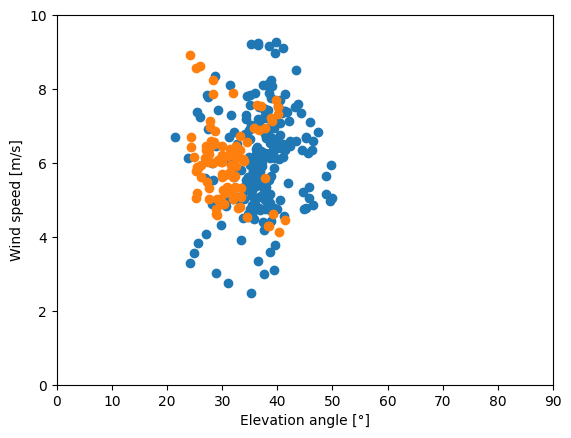

In [80]:
fig = plt.figure()
plt.scatter(theo_27_09_1['elevation'], VEL_27_09_1.sel(height=60))
plt.scatter(theo_27_09_2['elevation'], VEL_27_09_2.sel(height=60))
plt.xlabel('Elevation angle [°]')
plt.ylabel('Wind speed [m/s]')
plt.xlim(0,90)
plt.ylim(0,10)